# Random Forest


In [1]:
# import
import pickle

import numpy as np
np.random.seed(42)

from sklearn.model_selection import GridSearchCV,KFold 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, root_mean_squared_error


In [2]:
taille_fenetre_to_run = 50
taille_stride_to_run = 20
# TODO : taille_stride_to_run = 20 (peut etre TODO dans le gridsearch)
assert taille_fenetre_to_run in [50, 100, 150]

In [3]:
data = pickle.load(open(f"Data/donnees_{taille_fenetre_to_run}w_{taille_stride_to_run}s.pkl", "rb"))

In [4]:
data.keys()

dict_keys(['X_np_label', 'X_np_binary', 'y_np', 'features_names_label', 'features_names_binary'])

In [5]:
X_np_label = data["X_np_label"]
y_np = data["y_np"]

In [6]:
features_label = data["features_names_label"]

In [8]:
# # Vérifier que toutes les données de X_np_label sont entre 0 et 1
# for i in range(X_np_label.shape[0]):
#     for j in range(X_np_label.shape[1]):
#         for k in range(X_np_label.shape[2]):
#             if k != 17:
#                 assert X_np_label[i, j, k] >= 0 and X_np_label[i, j, k] <= 1

In [9]:
X_np_label.shape

(4711, 362)

In [10]:
# # PAS ICI ON UTILISE DEJA LES DONNEES ISSUE DE FLATTEN 
# # reshape les données 3D pour les adapter à un random forest
# X_reshape = X_np_label.reshape(X_np_label.shape[0], -1)

In [11]:
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=42, shuffle=True) 
# LSTM : on pourrait tester stratified (surtout dans lstm où performance dépend vraiment du split) pour l'instante)

mse_scores = []
mae_scores = []
mape_scores = []
rmse_scores = []

rf = RandomForestRegressor(n_estimators=100, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X_np_label)):
    print(f"Running fold {fold+1}/{n_splits}")
    # X_train, X_test = X_reshape[train_index], X_reshape[test_index]
    X_train, X_test = X_np_label[train_index], X_np_label[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]
    
    rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

    y_pred = rf.predict(X_test.reshape(X_test.shape[0], -1))

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    mse_scores.append(mse)
    mae_scores.append(mae)
    mape_scores.append(mape)
    rmse_scores.append(rmse)

    # save the model to disk
    filename = f'Models/RandomForest_{taille_fenetre_to_run}_fold_{fold}.sav'
    pickle.dump(rf, open(filename, 'wb'))
    

Running fold 1/5
Running fold 2/5
Running fold 3/5
Running fold 4/5
Running fold 5/5


In [12]:
print(f"Mean MSE: {np.mean(mse_scores)}")
print(f"Mean MAE: {np.mean(mae_scores)}")
print(f"Mean MAPE: {np.mean(mape_scores)}")
print(f"Mean RMSE: {np.mean(rmse_scores)}")

Mean MSE: 0.2517663034035552
Mean MAE: 0.28143293198654185
Mean MAPE: 0.0030248104060552677
Mean RMSE: 0.4898939932970315


In [13]:
print(f'MSE scores: {mse_scores}')
print(f'MAE scores: {mae_scores}')
print(f'MAPE scores: {mape_scores}')
print(f'RMSE scores: {rmse_scores}')

MSE scores: [np.float64(0.16848669924411466), np.float64(0.49159864627894256), np.float64(0.22605877639500355), np.float64(0.20379949216358226), np.float64(0.16888790293613307)]
MAE scores: [np.float64(0.26019089502871023), np.float64(0.30326466375908956), np.float64(0.30013651077638775), np.float64(0.28027095408338104), np.float64(0.2633016362851406)]
MAPE scores: [np.float64(0.0027855338682594498), np.float64(0.0032765455072127575), np.float64(0.0032327354229783594), np.float64(0.003005158385016118), np.float64(0.002824078846809654)]
RMSE scores: [np.float64(0.4104713135459221), np.float64(0.7011409603488749), np.float64(0.47545638747944435), np.float64(0.451441571151331), np.float64(0.41095973395958524)]


In [21]:
# get meilleur fold
best_fold = np.argmin(mse_scores)
print(f"Best fold: {best_fold}")

# Si vous êtes strict sur la validation ou travaillez avec de grandes quantités de données, préférez le meilleur modèle de KFold.

Best fold: 2


In [22]:
rf_best = pickle.load(open(f'Models/RandomForest_{taille_fenetre_to_run}_fold_{best_fold}.sav', 'rb'))

In [14]:
# NOTES : 
# TODO : mettre en place dans autre fichier gridsearch 
# taille de fenetre (mais on pourrait aussi tester avec 
# stride différent... à voir à quel point c'est long )
# n_estimators
# max_depth
# min_samples_split
# min_samples_leaf
# max_features
# bootstrap
# criterion
# etc

# enfaite si on fait le gridsearch sur taille de fenetre d'abord en random forest
# ensuite on peut dire qu'on utilise meme taille de fenetre / stride pour rnn et linéaire 


# TODO : pas prendre un modèle de la validation croisée mais 
# directement un modèle (sinon biais ?)

# TODO : lstm : RMSE

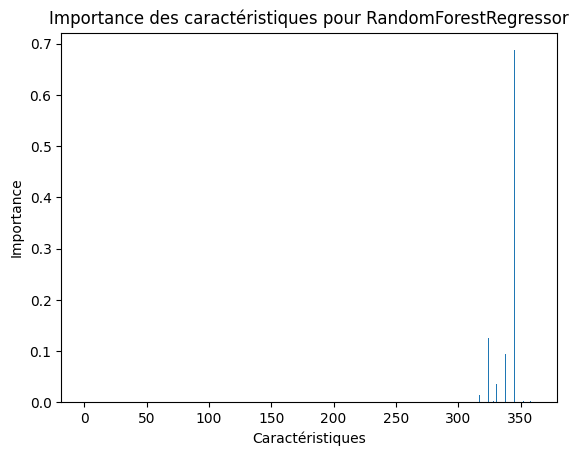

In [23]:
import matplotlib.pyplot as plt

# Récupérer l'importance des caractéristiques
feature_importances = rf_best.feature_importances_

# Afficher l'importance des caractéristiques sous forme de graphique
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Caractéristiques')
plt.ylabel('Importance')
plt.title('Importance des caractéristiques pour RandomForestRegressor')
plt.show()


In [24]:
print(len(features_label))
print(X_np_label.shape)
print(len(feature_importances))
# ok tout semble cohérent 

362
(4711, 362)
362


In [25]:
# TODO ce serait bien de regrouper par window idx et un regroupement par feature pour explicabilité 

In [26]:
import shap

# Créer un explainer SHAP pour RandomForest
explainer = shap.TreeExplainer(rf_best)

# Calculer les valeurs SHAP pour les données de test
shap_values = explainer.shap_values(X_test)

# Visualiser les valeurs SHAP pour une prédiction
shap.initjs()  # Pour activer les visualisations interactives
# shap.summary_plot(shap_values, X_test)


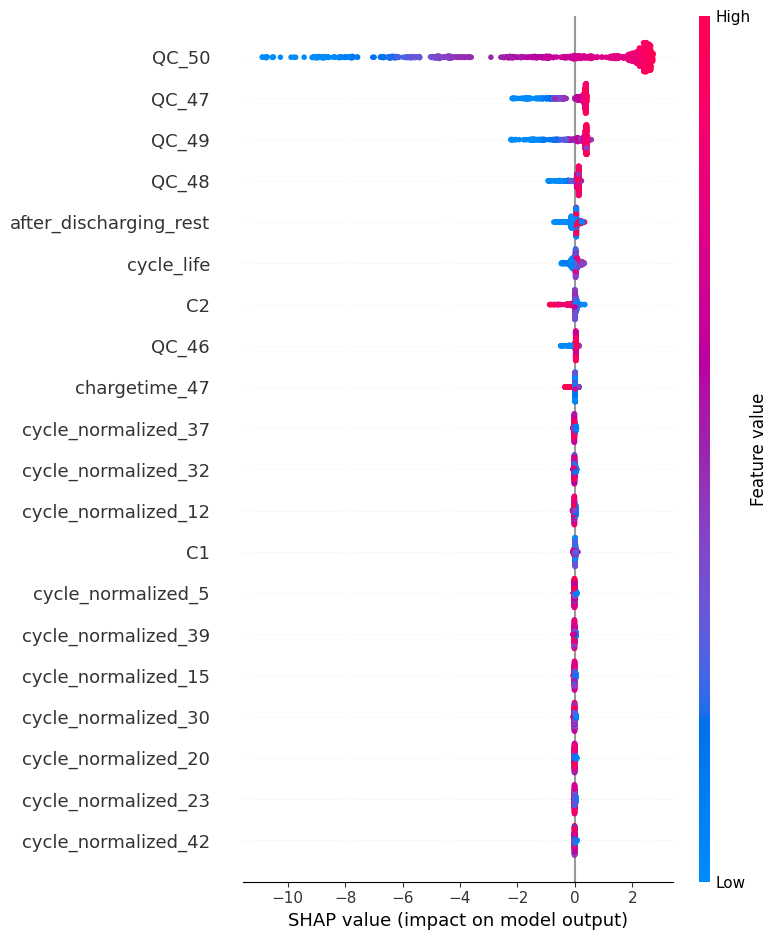

In [27]:
shap.summary_plot(shap_values, X_test, feature_names=features_label)
